In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans as SklearnKMeans
import time

In [23]:
df = pd.read_csv("/content/Mall_Customers.csv")
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [25]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000



Summary Statistics:


,Age,Income,Spending
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


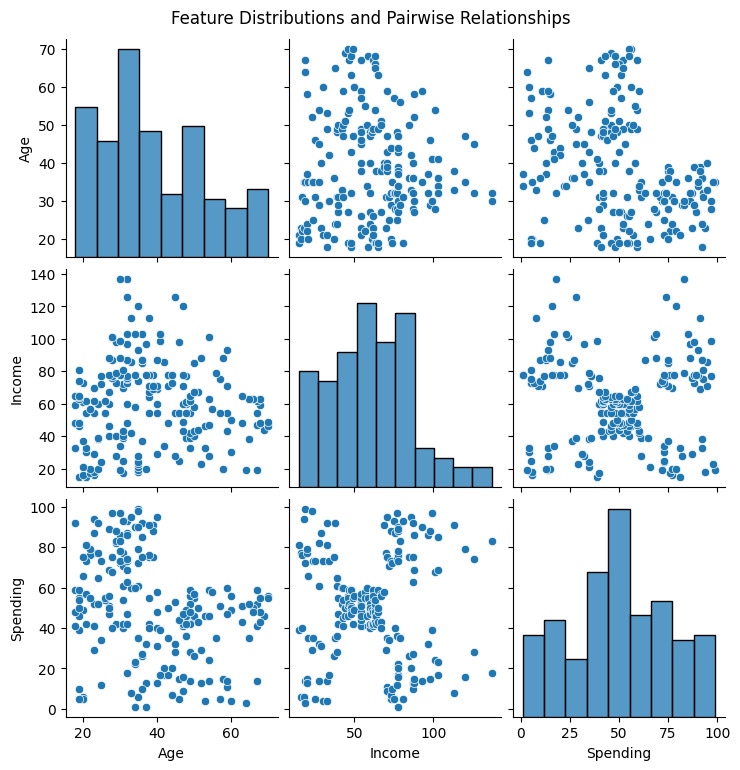

In [26]:
X = df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("\nSummary Statistics:")
display(pd.DataFrame(X, columns=['Age','Income','Spending']).describe())

sns.pairplot(pd.DataFrame(X, columns=['Age','Income','Spending']))
plt.suptitle("Feature Distributions and Pairwise Relationships", y=1.02)
plt.show()



In [27]:
def initialize_centroids(X, k, random_state=None):
    np.random.seed(random_state)
    indices = np.random.choice(len(X), k, replace=False)
    return X[indices]

def kmeans_plus_plus_init(X, k, random_state=None):
    np.random.seed(random_state)
    centroids = []
    centroids.append(X[np.random.randint(X.shape[0])])
    for _ in range(1, k):
        dist_sq = np.min([np.sum((X - c) ** 2, axis=1) for c in centroids], axis=0)
        probs = dist_sq / np.sum(dist_sq)
        cumulative_probs = np.cumsum(probs)
        r = np.random.rand()
        for j, p in enumerate(cumulative_probs):
            if r < p:
                centroids.append(X[j])
                break
    return np.array(centroids)

def assign_clusters(X, centroids):
    distances = np.sqrt(((X - centroids[:, np.newaxis])**2).sum(axis=2))
    return np.argmin(distances, axis=0)

def update_centroids(X, labels, k):
    new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(k)])
    return new_centroids

def kmeans(X, k, max_iters=100, tol=1e-4, random_state=None, init_method='random'):
    if init_method == 'kmeans++':
        centroids = kmeans_plus_plus_init(X, k, random_state)
    else:
        centroids = initialize_centroids(X, k, random_state)

    for i in range(max_iters):
        old_centroids = centroids.copy()
        labels = assign_clusters(X, centroids)
        centroids = update_centroids(X, labels, k)
        if np.linalg.norm(centroids - old_centroids) < tol:
            break

    inertia = np.sum([np.min(np.sum((X[labels == i] - centroids[i])**2, axis=1)) for i in range(k)])
    return centroids, labels, i+1, inertia


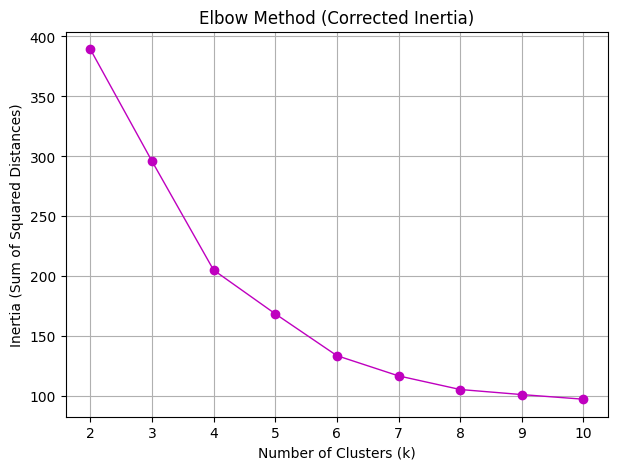

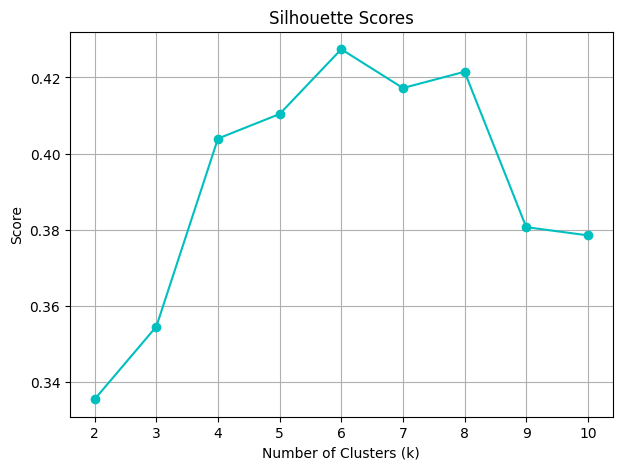

In [28]:

def compute_inertia(X, centroids, labels):
    inertia = 0
    for i in range(len(centroids)):
        cluster_points = X[labels == i]
        inertia += np.sum((cluster_points - centroids[i])**2)
    return inertia

inertias = []
sil_scores = []
K = range(2, 11)

for k in K:
    centroids, labels, iters, _ = kmeans(X_scaled, k, init_method='kmeans++', random_state=42)
    inertia = compute_inertia(X_scaled, centroids, labels)
    inertias.append(inertia)
    sil_scores.append(silhouette_score(X_scaled, labels))

# Elbow Plot
plt.figure(figsize=(7,5))
plt.plot(K, inertias, 'bo-', linewidth=1,color='m')
plt.title('Elbow Method (Corrected Inertia)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.grid(True)
plt.show()

# Silhouette Plot
plt.figure(figsize=(7,5))
plt.plot(K, sil_scores, 'ro-',color='c')
plt.title('Silhouette Scores')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Score')
plt.grid(True)
plt.show()

OPTIMAL K VALUE FROM THOSE TWO METHODS SUGGESTS K=[4-6]


In [29]:
optimal_k = 6
print(f"Chosen k according to elbow & silhouette= {optimal_k}")

Chosen k according to elbow & silhouette= 6



Final Centroids (Standardized):
[[ 1.25472096 -0.24021294 -0.04399777]
 [-0.44191719  0.99158305  1.23950275]
 [-0.97602698 -1.32549704  1.0371827 ]
 [ 0.22171558  1.08322527 -1.29005223]
 [-0.87309844 -0.11378508 -0.09358039]
 [ 0.47895722 -1.30822992 -1.19644353]]

Iterations: 10, Inertia: 0.3014649555772244

Cluster Averages:
                Age  Annual Income (k$)  Spending Score (1-100)
Cluster                                                       
0        56.333333           54.266667               49.066667
1        32.692308           86.538462               82.128205
2        25.250000           25.833333               76.916667
3        41.939394           88.939394               16.969697
4        26.684211           57.578947               47.789474
5        45.523810           26.285714               19.380952


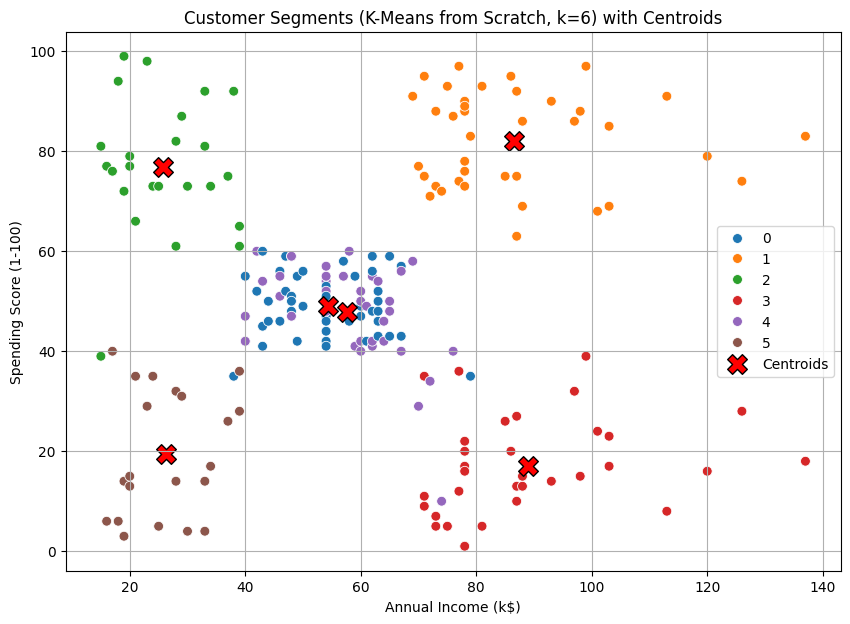

In [30]:

centroids, labels, iters, inertia = kmeans(X_scaled, optimal_k, init_method='kmeans++', random_state=42)
df['Cluster'] = labels

print(f"\nFinal Centroids (Standardized):\n{centroids}")
print(f"\nIterations: {iters}, Inertia: {inertia}")

cluster_summary = df.groupby('Cluster')[['Age','Annual Income (k$)','Spending Score (1-100)']].mean()
print("\nCluster Averages:\n", cluster_summary)

plt.figure(figsize=(10,7))
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', hue='Cluster', palette='tab10', data=df, legend='full', s=50)

plt.scatter(
    centroids[:, 1] * scaler.scale_[1] + scaler.mean_[1],
    centroids[:, 2] * scaler.scale_[2] + scaler.mean_[2],
    marker='X',
    s=200,
    color='red',
    edgecolor='black',
    label='Centroids'
)
plt.title(f"Customer Segments (K-Means from Scratch, k={optimal_k}) with Centroids")
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend()
plt.grid(True)
plt.show()


--- sklearn KMeans Comparison ---
Centroids:
 [[ 1.25472096 -0.24021294 -0.04399777]
 [-0.44191719  0.99158305  1.23950275]
 [-0.95377931 -1.30081415  1.01091344]
 [-0.91323113 -0.0433223  -0.22322397]
 [ 0.36959845  1.12879725 -1.25264236]
 [ 0.47895722 -1.30822992 -1.19644353]]
Inertia: 134.35277477401493
Iterations: 6
Runtime: 0.0054 seconds


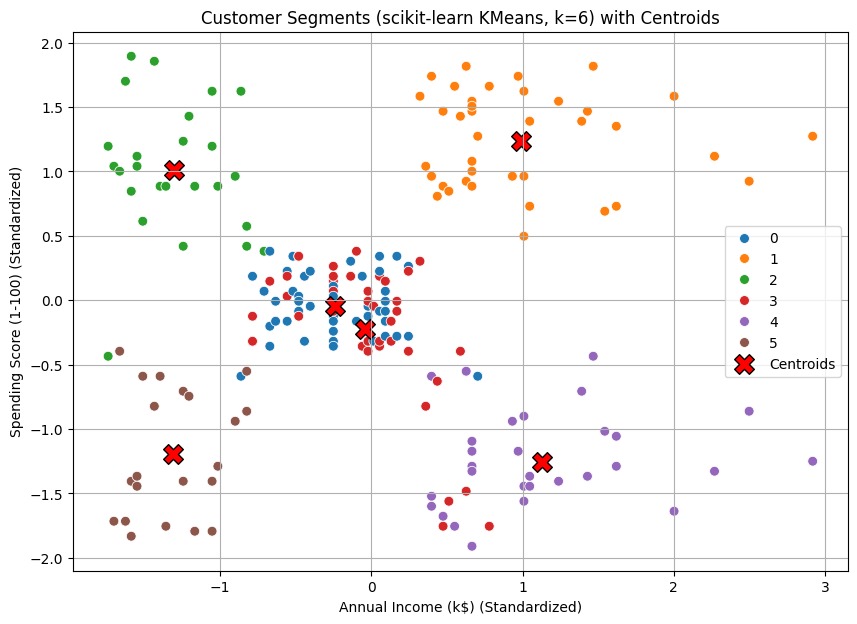

In [31]:

start = time.time()
sk_kmeans = SklearnKMeans(n_clusters=optimal_k, random_state=42, init='k-means++')
sk_labels = sk_kmeans.fit_predict(X_scaled)
end = time.time()

print("\n--- sklearn KMeans Comparison ---")
sk_centroids = sk_kmeans.cluster_centers_
print("Centroids:\n", sk_centroids)
print("Inertia:", sk_kmeans.inertia_)
print("Iterations:", sk_kmeans.n_iter_)
print(f"Runtime: {end - start:.4f} seconds")

plt.figure(figsize=(10,7))

sns.scatterplot(x=X_scaled[:,1], y=X_scaled[:,2], hue=sk_labels, palette='tab10', legend='full', s=50)

plt.scatter(
    sk_centroids[:, 1],
    sk_centroids[:, 2],
    marker='X',
    s=200,
    color='red',
    edgecolor='black',
    label='Centroids'
)
plt.title(f"Customer Segments (scikit-learn KMeans, k={optimal_k}) with Centroids")
plt.xlabel('Annual Income (k$) (Standardized)')
plt.ylabel('Spending Score (1-100) (Standardized)')
plt.legend()
plt.grid(True)
plt.show()